# **Secondary Stock Data Preprocessing Notebook**
## In this notebook we will preprocess our secondary stock data, first creating our lag windows and the custom features that come from expanding the resulting view.  Then we will do any necessary cleaning such as reviewing outliers and missing values in our expanded data, imputing as needed so we have a clean dataset going into the next phase of the project.

#### Let's start by bringing in the libraries and logic necessary for reading in our file.

In [1]:

import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy import stats



#### Now let's read in our data that we need for this notebook.

In [2]:
# Now let's access the main core_stock_data.csv file
csv_path = os.path.join(project_root, 'data', 'secondary_stocks_gen.csv')
sec_stock_data = pd.read_csv(csv_path, parse_dates=['Date'], index_col= 'Date')
print(sec_stock_data.head())
print(sec_stock_data.shape)

           ticker   Close_sec  Volume_sec    Open_sec    High_sec     Low_sec  \
Date                                                                            
2019-03-14    RMD  101.000000      972500  102.570000  102.570000  100.959999   
2019-03-15    RMD  100.370003     2279400  100.900002  101.730003  100.199997   
2019-03-18    RMD   97.400002     1915700  100.360001  100.610001   96.940002   
2019-03-19    RMD   97.900002     1101100   97.660004   98.190002   97.070000   
2019-03-20    RMD   98.809998     1467600   99.129997  100.800003   98.449997   

             SMA_sec     EMA_sec    RSI_sec   BBM_sec  ...  CCI_20_sec  \
Date                                                   ...               
2019-03-14  104.9046  101.000000  63.818062  104.9046  ...  166.103556   
2019-03-15  104.9046  100.975294  63.818062  104.9046  ...  166.103556   
2019-03-18  104.9046  100.835087  63.818062  104.9046  ...  166.103556   
2019-03-19  104.9046  100.719985  63.818062  104.9046  ...  16

#### The first step I want to undertake is handling and imputing any missing features.  I want to do this first so that when we create our lag windows and resulting custom features the new values will be calculated properly, and it will be easier to address our resulting outliers.  We will look at the same process that we used for our core stock data, a combination of ffill, bfill and linear interpolation for max efficiency of our missing values.

In [3]:
def fill_missing_vals(df):
    df.ffill(inplace = True)
    df.bfill(inplace = True)
    df.interpolate(method = 'linear', inplace = True)
    
    return df

sec_stock_data = sec_stock_data.copy()

for col in sec_stock_data.columns:
    if sec_stock_data[col].isnull().any():
        sec_stock_data.loc[:, col] = fill_missing_vals(sec_stock_data[[col]])[col]



print(sec_stock_data.isna().sum())

ticker             0
Close_sec          0
Volume_sec         0
Open_sec           0
High_sec           0
Low_sec            0
SMA_sec            0
EMA_sec            0
RSI_sec            0
BBM_sec            0
BBU_sec            0
BBL_sec            0
MACD_sec           0
MACD_Signal_sec    0
MACD_Hist_sec      0
ADX_14_sec         0
CCI_20_sec         0
ATR_14_sec         0
Stoch_K_sec        0
Stoch_D_sec        0
Momentum_1_sec     0
Momentum_3_sec     0
Momentum_7_sec     0
Momentum_30_sec    0
Momentum_50_sec    0
OBV_sec            0
dtype: int64


C:\Users\ryanm\AppData\Local\Temp\ipykernel_13812\798176148.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.ffill(inplace = True)
C:\Users\ryanm\AppData\Local\Temp\ipykernel_13812\798176148.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.bfill(inplace = True)
C:\Users\ryanm\AppData\Local\Temp\ipykernel_13812\798176148.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.interpolate(method = 'linear', inplace = True)
C:\

#### Looks great, now let's create the lag windows and custom features for our secondary stocks.

In [4]:
# We will need to create a temp variable since we are making so many custom features, it will otherwise create a PerformanceWarning since when we execute the cell on our main df its too much at once.
# By storing all the custom features to a temp variable and then concatenating them in a separate step it takes the pressure off in the execute phase.
new_temp_columns = pd.DataFrame(index = sec_stock_data.index)

# Now let's create a variable to house our features we want to create lag features for.
features_to_lag = ['Open_sec', 'High_sec', 'Low_sec', 'Volume_sec','Close_sec', 'EMA_sec', 'SMA_sec', 'RSI_sec', 'BBM_sec', 'BBL_sec', 'BBU_sec', 'MACD_sec', 'MACD_Signal_sec', 'MACD_Hist_sec', 'ADX_14_sec', 'CCI_20_sec', 'ATR_14_sec', 'Stoch_K_sec', 'Stoch_D_sec', 'Momentum_1_sec', 'Momentum_3_sec', 'Momentum_7_sec', 'Momentum_30_sec', 'Momentum_50_sec', 'OBV_sec']

# Now we apply the lag windows with a small 3-day window size.
for feature in features_to_lag:
    for lag in range(1,4):
        new_temp_columns[f'{feature}_Lag_{lag}'] = sec_stock_data[feature].shift(lag)

# Great, now from these new lag-based features let's expand on it further by creating some custom features using our existing ones.
new_temp_columns['Close_Lag_Avg_1_3_sec'] = new_temp_columns[['Close_sec_Lag_1', 'Close_sec_Lag_2', 'Close_sec_Lag_3']].mean(axis = 1)
new_temp_columns['Close_Lag_Std_1_3_sec'] = new_temp_columns[['Close_sec_Lag_1', 'Close_sec_Lag_2', 'Close_sec_Lag_3']].std(axis = 1)

new_temp_columns['Open_Lag_Avg_1_3_sec'] = new_temp_columns[['Open_sec_Lag_1', 'Open_sec_Lag_2', 'Open_sec_Lag_3']].mean(axis = 1)
new_temp_columns['Open_Lag_Std_1_3_sec'] = new_temp_columns[['Open_sec_Lag_1', 'Open_sec_Lag_2', 'Open_sec_Lag_3']].std(axis = 1)

new_temp_columns['High_Lag_Avg_1_3_sec'] = new_temp_columns[['High_sec_Lag_1', 'High_sec_Lag_2', 'High_sec_Lag_3']].mean(axis = 1)
new_temp_columns['High_Lag_Std_1_3_sec'] = new_temp_columns[['High_sec_Lag_1', 'High_sec_Lag_2', 'High_sec_Lag_3']].std(axis = 1)

new_temp_columns['Low_Lag_Avg_1_3_sec'] = new_temp_columns[['Low_sec_Lag_1', 'Low_sec_Lag_2', 'Low_sec_Lag_3']].mean(axis = 1)
new_temp_columns['Low_Lag_Std_1_3_sec'] = new_temp_columns[['Low_sec_Lag_1', 'Low_sec_Lag_2', 'Low_sec_Lag_3']].std(axis = 1)

new_temp_columns['Volume_Lag_Avg_1_3_sec'] = new_temp_columns[['Volume_sec_Lag_1', 'Volume_sec_Lag_2', 'Volume_sec_Lag_3']].mean(axis = 1)
new_temp_columns['Volume_Lag_Std_1_3_sec'] = new_temp_columns[['Volume_sec_Lag_1', 'Volume_sec_Lag_2', 'Volume_sec_Lag_3']].std(axis = 1)

new_temp_columns['EMA_Lag_Avg_1_3_sec'] = new_temp_columns[['EMA_sec_Lag_1', 'EMA_sec_Lag_2', 'EMA_sec_Lag_3']].mean(axis = 1)
new_temp_columns['EMA_Lag_Std_1_3_sec'] = new_temp_columns[['EMA_sec_Lag_1', 'EMA_sec_Lag_2', 'EMA_sec_Lag_3']].std(axis = 1)

new_temp_columns['SMA_Lag_Avg_1_3_sec'] = new_temp_columns[['SMA_sec_Lag_1', 'SMA_sec_Lag_2', 'SMA_sec_Lag_3']].mean(axis = 1)
new_temp_columns['SMA_Lag_Std_1_3_sec'] = new_temp_columns[['SMA_sec_Lag_1', 'SMA_sec_Lag_2', 'SMA_sec_Lag_3']].std(axis = 1)

new_temp_columns['RSI_Lag_Avg_1_3_sec'] = new_temp_columns[['RSI_sec_Lag_1', 'RSI_sec_Lag_2', 'RSI_sec_Lag_3']].mean(axis = 1)
new_temp_columns['RSI_Lag_Std_1_3_sec'] = new_temp_columns[['RSI_sec_Lag_1', 'RSI_sec_Lag_2', 'RSI_sec_Lag_3']].std(axis = 1)

new_temp_columns['BBM_Lag_Avg_1_3_sec'] = new_temp_columns[['BBM_sec_Lag_1', 'BBM_sec_Lag_2', 'BBM_sec_Lag_3']].mean(axis = 1)
new_temp_columns['BBM_Lag_Std_1_3_sec'] = new_temp_columns[['BBM_sec_Lag_1', 'BBM_sec_Lag_2', 'BBM_sec_Lag_3']].std(axis = 1)

new_temp_columns['BBU_Lag_Avg_1_3_sec'] = new_temp_columns[['BBU_sec_Lag_1', 'BBU_sec_Lag_2', 'BBU_sec_Lag_3']].mean(axis = 1)
new_temp_columns['BBU_Lag_Std_1_3_sec'] = new_temp_columns[['BBU_sec_Lag_1', 'BBU_sec_Lag_2', 'BBU_sec_Lag_3']].std(axis = 1)

new_temp_columns['BBL_Lag_Avg_1_3_sec'] = new_temp_columns[['BBL_sec_Lag_1', 'BBL_sec_Lag_2', 'BBL_sec_Lag_3']].mean(axis = 1)
new_temp_columns['BBL_Lag_Std_1_3_sec'] = new_temp_columns[['BBL_sec_Lag_1', 'BBL_sec_Lag_2', 'BBL_sec_Lag_3']].std(axis = 1)

new_temp_columns['Stoch_K_Lag_Avg_1_3_sec'] = new_temp_columns[['Stoch_K_sec_Lag_1', 'Stoch_K_sec_Lag_2', 'Stoch_K_sec_Lag_3']].mean(axis = 1)
new_temp_columns['Stoch_K_Lag_Std_1_3_sec'] = new_temp_columns[['Stoch_K_sec_Lag_1', 'Stoch_K_sec_Lag_2', 'Stoch_K_sec_Lag_3']].std(axis = 1)

new_temp_columns['Stoch_D_Lag_Avg_1_3_sec'] = new_temp_columns[['Stoch_D_sec_Lag_1', 'Stoch_D_sec_Lag_2', 'Stoch_D_sec_Lag_3']].mean(axis = 1)
new_temp_columns['Stoch_D_Lag_Std_1_3_sec'] = new_temp_columns[['Stoch_D_sec_Lag_1', 'Stoch_D_sec_Lag_2', 'Stoch_D_sec_Lag_3']].std(axis = 1)

new_temp_columns['MACD_Lag_Avg_1_3_sec'] = new_temp_columns[['MACD_sec_Lag_1', 'MACD_sec_Lag_2', 'MACD_sec_Lag_3']].mean(axis = 1)
new_temp_columns['MACD_Lag_Std_1_3_sec'] = new_temp_columns[['MACD_sec_Lag_1', 'MACD_sec_Lag_2', 'MACD_sec_Lag_3']].std(axis = 1)

new_temp_columns['MACD_Signal_Lag_Avg_1_3_sec'] = new_temp_columns[['MACD_Signal_sec_Lag_1', 'MACD_Signal_sec_Lag_2', 'MACD_Signal_sec_Lag_3']].mean(axis = 1)
new_temp_columns['MACD_Signal_Lag_Std_1_3_sec'] = new_temp_columns[['MACD_Signal_sec_Lag_1', 'MACD_Signal_sec_Lag_2', 'MACD_Signal_sec_Lag_3']].std(axis = 1)

new_temp_columns['MACD_Hist_Avg_1_3_sec'] = new_temp_columns[['MACD_Hist_sec_Lag_1', 'MACD_Hist_sec_Lag_2', 'MACD_Hist_sec_Lag_3']].mean(axis = 1)
new_temp_columns['MACD_Hist_Lag_Std_1_3_sec'] = new_temp_columns[['MACD_Hist_sec_Lag_1', 'MACD_Hist_sec_Lag_2', 'MACD_Hist_sec_Lag_3']].std(axis = 1)

new_temp_columns['ADX_14_Lag_Avg_1_3_sec'] = new_temp_columns[['ADX_14_sec_Lag_1', 'ADX_14_sec_Lag_2', 'ADX_14_sec_Lag_3']].mean(axis = 1)
new_temp_columns['ADX_14_Lag_Std_1_3_sec'] = new_temp_columns[['ADX_14_sec_Lag_1', 'ADX_14_sec_Lag_2', 'ADX_14_sec_Lag_3']].std(axis = 1)

new_temp_columns['CCI_20_Lag_Avg_1_3_sec'] = new_temp_columns[['CCI_20_sec_Lag_1', 'CCI_20_sec_Lag_2', 'CCI_20_sec_Lag_3']].mean(axis = 1)
new_temp_columns['CCI_20_Lag_Std_1_3_sec'] = new_temp_columns[['CCI_20_sec_Lag_1', 'CCI_20_sec_Lag_2', 'CCI_20_sec_Lag_3']].std(axis = 1)

new_temp_columns['ATR_14_Lag_Avg_1_3_sec'] = new_temp_columns[['ATR_14_sec_Lag_1', 'ATR_14_sec_Lag_2', 'ATR_14_sec_Lag_3']].mean(axis = 1)
new_temp_columns['ATR_14_Lag_Std_1_3_sec'] = new_temp_columns[['ATR_14_sec_Lag_1', 'ATR_14_sec_Lag_2', 'ATR_14_sec_Lag_3']].std(axis = 1)

new_temp_columns['Momentum_1_Lag_Avg_1_3_sec'] = new_temp_columns[['Momentum_1_sec_Lag_1', 'Momentum_1_sec_Lag_2', 'Momentum_1_sec_Lag_3']].mean(axis = 1)
new_temp_columns['Momentum_1_Lag_Std_1_3_sec'] = new_temp_columns[['Momentum_1_sec_Lag_1', 'Momentum_1_sec_Lag_2', 'Momentum_1_sec_Lag_3']].std(axis = 1)

new_temp_columns['Momentum_3_Lag_Avg_1_3_sec'] = new_temp_columns[['Momentum_3_sec_Lag_1', 'Momentum_3_sec_Lag_2', 'Momentum_3_sec_Lag_3']].mean(axis = 1)
new_temp_columns['Momentum_3_Lag_Std_1_3_sec'] = new_temp_columns[['Momentum_3_sec_Lag_1', 'Momentum_3_sec_Lag_2', 'Momentum_3_sec_Lag_3']].std(axis = 1)

new_temp_columns['Momentum_7_Lag_Avg_1_3_sec'] = new_temp_columns[['Momentum_7_sec_Lag_1', 'Momentum_7_sec_Lag_2', 'Momentum_7_sec_Lag_3']].mean(axis = 1)
new_temp_columns['Momentum_7_Lag_Std_1_3_sec'] = new_temp_columns[['Momentum_7_sec_Lag_1', 'Momentum_7_sec_Lag_2', 'Momentum_7_sec_Lag_3']].std(axis = 1)

new_temp_columns['Momentum_30_Lag_Avg_1_3_sec'] = new_temp_columns[['Momentum_30_sec_Lag_1', 'Momentum_30_sec_Lag_2', 'Momentum_30_sec_Lag_3']].mean(axis = 1)
new_temp_columns['Momentum_30_Lag_Std_1_3_sec'] = new_temp_columns[['Momentum_30_sec_Lag_1', 'Momentum_30_sec_Lag_2', 'Momentum_30_sec_Lag_3']].std(axis = 1)

new_temp_columns['Momentum_50_Lag_Avg_1_3_sec'] = new_temp_columns[['Momentum_50_sec_Lag_1', 'Momentum_50_sec_Lag_2', 'Momentum_50_sec_Lag_3']].mean(axis = 1)
new_temp_columns['Momentum_50_Lag_Std_1_3_sec'] = new_temp_columns[['Momentum_50_sec_Lag_1', 'Momentum_50_sec_Lag_2', 'Momentum_50_sec_Lag_3']].std(axis = 1)

new_temp_columns['OBV_Lag_Avg_1_3_sec'] = new_temp_columns[['OBV_sec_Lag_1', 'OBV_sec_Lag_2', 'OBV_sec_Lag_3']].mean(axis = 1)
new_temp_columns['OBV_Lag_Std_1_3_sec'] = new_temp_columns[['OBV_sec_Lag_1', 'OBV_sec_Lag_2', 'OBV_sec_Lag_3']].std(axis = 1)

new_temp_columns['Close_Lag_Avg_1_3_sec'] = new_temp_columns[['Close_sec_Lag_1', 'Close_sec_Lag_2', 'Close_sec_Lag_3']].mean(axis = 1)
new_temp_columns['Close_Lag_Std_1_3_sec'] = new_temp_columns[['Close_sec_Lag_1', 'Close_sec_Lag_2', 'Close_sec_Lag_3']].std(axis = 1)

new_temp_columns['Diff_Close_EMA_sec'] = sec_stock_data['Close_sec'] - sec_stock_data['EMA_sec']
new_temp_columns['Ratio_Close_EMA_sec'] = sec_stock_data['Close_sec'] / sec_stock_data['EMA_sec']

# Now we can concatenate onto our original core_stock_data.
sec_stock_data = pd.concat([sec_stock_data, new_temp_columns], axis = 1)

print(sec_stock_data.head())

#print(core_stock_data.head(10))
print(sec_stock_data.isnull().sum())

C:\Users\ryanm\AppData\Local\Temp\ipykernel_13812\3132855747.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_temp_columns['Stoch_D_Lag_Std_1_3_sec'] = new_temp_columns[['Stoch_D_sec_Lag_1', 'Stoch_D_sec_Lag_2', 'Stoch_D_sec_Lag_3']].std(axis = 1)
C:\Users\ryanm\AppData\Local\Temp\ipykernel_13812\3132855747.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_temp_columns['MACD_Lag_Avg_1_3_sec'] = new_temp_columns[['MACD_sec_Lag_1', 'MACD_sec_Lag_2', 'MACD_sec_Lag_3']].mean(axis = 1)
C:\Users\ryanm\AppData\Local\Temp

           ticker   Close_sec  Volume_sec    Open_sec    High_sec     Low_sec  \
Date                                                                            
2019-03-14    RMD  101.000000      972500  102.570000  102.570000  100.959999   
2019-03-15    RMD  100.370003     2279400  100.900002  101.730003  100.199997   
2019-03-18    RMD   97.400002     1915700  100.360001  100.610001   96.940002   
2019-03-19    RMD   97.900002     1101100   97.660004   98.190002   97.070000   
2019-03-20    RMD   98.809998     1467600   99.129997  100.800003   98.449997   

             SMA_sec     EMA_sec    RSI_sec   BBM_sec  ...  \
Date                                                   ...   
2019-03-14  104.9046  101.000000  63.818062  104.9046  ...   
2019-03-15  104.9046  100.975294  63.818062  104.9046  ...   
2019-03-18  104.9046  100.835087  63.818062  104.9046  ...   
2019-03-19  104.9046  100.719985  63.818062  104.9046  ...   
2019-03-20  104.9046  100.645084  63.818062  104.9046  ...  

#### It looks like through the creation of all of our new features there are just a few missing values that slipped through.  Let's re-run our imputation logic to take care of them.  Also since I see 0s in our .head() printout, we will address those in our function below as leaving those will cause issues down the road with our outlier calculations.

In [5]:

def fill_missing_vals(df):
    # Ensure we're only applying the logic to numeric columns
    numeric_cols = df.select_dtypes(include=[np.number])
    
    # Replace any 0s or negative values with extremely small positive integers
    numeric_cols = numeric_cols.apply(lambda x: np.where(x <= 0, 1e-10, x))
    
    # Impute missing values with the following methodologies    
    numeric_cols.ffill(inplace=True)
    numeric_cols.bfill(inplace=True)
    numeric_cols.interpolate(method='linear', inplace=True)
    
    # Update the original dataframe with the modified numeric columns
    df[numeric_cols.columns] = numeric_cols
    
    return df

sec_stock_data = sec_stock_data.copy()

# Apply fill_missing_vals only to numeric columns with missing values
sec_stock_data = fill_missing_vals(sec_stock_data)

print("Missing values handled:")
print(sec_stock_data.isna().sum())

# We will also put in a check for extremely large values as we are seeing warnings for those below
def replace_large_values(df, threshold=1e9):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Apply logic only to numeric columns
    numeric_cols = df.select_dtypes(include=[np.number])
    
    # Debug print statement to see what and how many values exceed our given threshold.
    print("Values exceeding the threshold before replacement:")
    for col in numeric_cols.columns:
        large_vals = numeric_cols[numeric_cols[col] > threshold]
        if not large_vals.empty:
            print(f"Column '{col}' has values larger than the threshold:")
            print(large_vals[col])
    
    # Replace large values with NaN
    numeric_cols = numeric_cols.applymap(lambda x: np.nan if x > 1e10 else x)
    
    # Apply the fill_missing_vals logic to impute the modified numeric columns
    numeric_cols = fill_missing_vals(numeric_cols)
    
    # Update the original dataframe with the modified numeric columns
    df[numeric_cols.columns] = numeric_cols
    
    return df

threshold_value = 1e9
sec_stock_data = replace_large_values(sec_stock_data, threshold=threshold_value)

# Calculate the max and min values only for numeric columns
numeric_cols = sec_stock_data.select_dtypes(include = [np.number])

print("Max value after replacement", numeric_cols.max().max())
print("Min value after replacement:", numeric_cols.min().min())


Missing values handled:
ticker                         0
Close_sec                      0
Volume_sec                     0
Open_sec                       0
High_sec                       0
                              ..
Momentum_50_Lag_Std_1_3_sec    0
OBV_Lag_Avg_1_3_sec            0
OBV_Lag_Std_1_3_sec            0
Diff_Close_EMA_sec             0
Ratio_Close_EMA_sec            0
Length: 153, dtype: int64
Values exceeding the threshold before replacement:
Column 'OBV_sec' has values larger than the threshold:
Date
2024-03-19    1.005040e+09
2024-03-20    1.013413e+09
2024-06-05    1.003576e+09
2024-06-06    1.010923e+09
2024-06-07    1.022468e+09
                  ...     
2021-05-11    1.210862e+09
2021-05-12    1.169180e+09
2021-05-13    1.205018e+09
2021-05-14    1.233063e+09
2021-05-17    1.006053e+09
Name: OBV_sec, Length: 4173, dtype: float64
Column 'OBV_sec_Lag_1' has values larger than the threshold:
Date
2024-03-20    1.005040e+09
2024-03-21    1.013413e+09
2024-06-06    1

C:\Users\ryanm\AppData\Local\Temp\ipykernel_13812\2341058908.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  numeric_cols = numeric_cols.applymap(lambda x: np.nan if x > 1e10 else x)


Max value after replacement 3405056000.0
Min value after replacement: 5.782411586589357e-19


#### Great, now let's look into viewing and handling outliers.  We will first see the appearance of outliers using z_score with a standard std of 3, and then looking at the column feature spread.

#### First though we will create a save point and a separate csv of our unscaled secondary stock data, as we will need this in an upcoming notebook.

In [6]:
sec_stock_data.to_csv(os.path.join(project_root, 'data', 'sec_stock_unscaled.csv'), index = True)

In [7]:

numeric_cols = sec_stock_data.select_dtypes(include = [np.number])
z_scores = np.abs(stats.zscore(numeric_cols))
threshold = 3 # Common threshold starting std modifier

outliers = (z_scores > threshold)

print(outliers.sum(axis = 0))


Close_sec                      3843
Volume_sec                     5614
Open_sec                       3856
High_sec                       3843
Low_sec                        3836
                               ... 
Momentum_50_Lag_Std_1_3_sec    3477
OBV_Lag_Avg_1_3_sec            5411
OBV_Lag_Std_1_3_sec            2890
Diff_Close_EMA_sec             3203
Ratio_Close_EMA_sec            3723
Length: 152, dtype: int64


#### Yes that is quite a few of outliers, but remember we have 200 different stocks representing 5 years of historical data in this dataframe.  Currently there is 276350 rows, so the existing amount of shown outliers represent a very small percentage and we will continue to work on them as we go forward.

#### Our Volume_sec feature in particular has an alarming amount of outliers, and as we know Volume is used to calculate a lot of our other other custom features.  We will need to normalize the Volume feature so we can figure out what's going on.  Let's take a closer look with a plot.

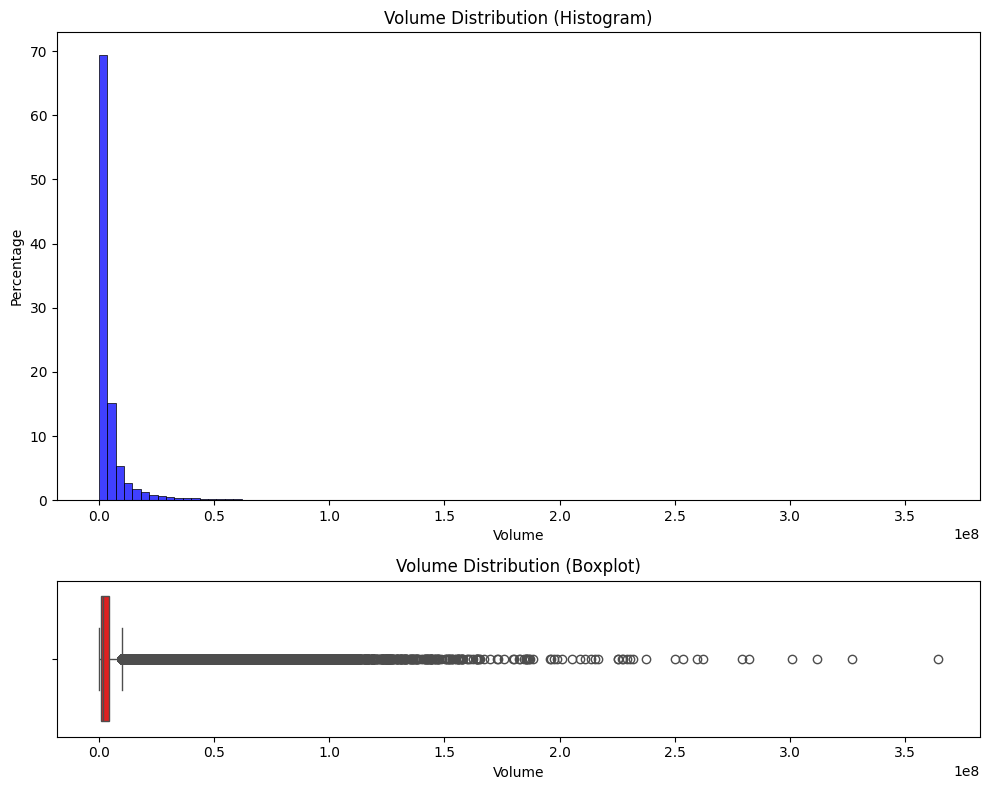

In [8]:
fig, ax = plt.subplots(2,1, figsize = (10, 8), gridspec_kw = {'height_ratios' : [3,1]})

sns.histplot(sec_stock_data['Volume_sec'], bins = 100, kde = False, ax = ax[0], stat = 'percent', color = 'b')
ax[0].set_title('Volume Distribution (Histogram)')
ax[0].set_xlabel('Volume')
ax[0].set_ylabel('Percentage')

sns.boxplot(x = sec_stock_data['Volume_sec'], ax = ax[1], color = 'r', whis = 1.5)
ax[1].set_title('Volume Distribution (Boxplot)')
ax[1].set_xlabel('Volume')


plt.tight_layout()
plt.show()

#### So the plot above tells us a few things about our Volume data.  It shows in the top portion that 70% of the Volume values have a very low trading volume.  As you move forward past that point the trading volumes increase but so do the number of observations for those points.  The boxplot below echoes this as well.  What this represents is that the large outliers (the smaller bars in the histogram that make up our outlier volume) could represent significant events or sudden spikes in activity.  As such further performance on our outliers is warranted so we can establish normal distribution.

In [9]:
def volume_log_transform(sec_stock_data):
    sec_stock_data['Volume_sec'] = np.log1p(sec_stock_data['Volume_sec'])
    return sec_stock_data

sec_stock_data = volume_log_transform(sec_stock_data)



#### Now we will replot the Volume feature to see how it looks after the log transform.

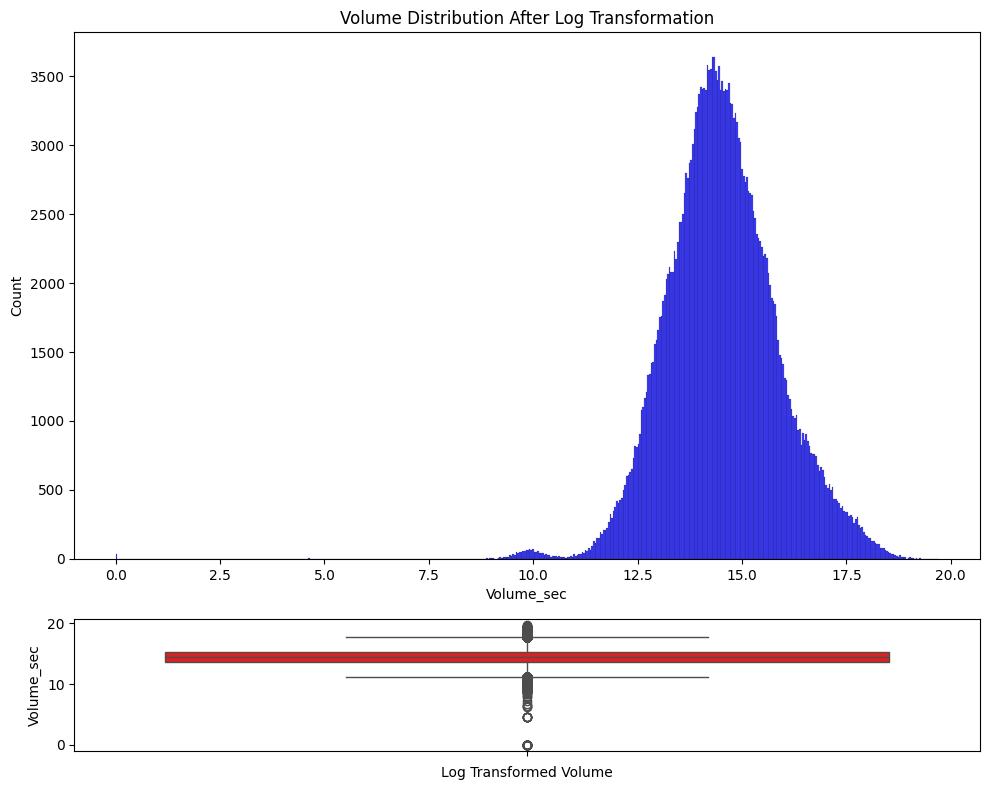

In [10]:
fig, (ax_hist, ax_box) = plt.subplots(
    2,
    figsize = (10,8),
    gridspec_kw = {'height_ratios' : [4,1]},
    )

sns.histplot(sec_stock_data['Volume_sec'], bins = 500, ax = ax_hist, color = 'blue')
ax_hist.set_title('Volume Distribution After Log Transformation')
ax_hist.set_ylabel('Count')

sns.boxplot(sec_stock_data['Volume_sec'], ax = ax_box, color = 'red')
ax_box.set_xlabel('Log Transformed Volume')

plt.tight_layout()
plt.show()


#### This is much better, there are noticeably fewer outliers shown in the top part of the plot and you can see the bell curve shape for our Volume feature.

#### Let's apply the log transform to the rest of our features, being careful not to duplicate any of our outlier detection activity.

In [11]:
def volume_log_transform_rest(sec_stock_data):
    # Get the rest of the features, removing Volume_Sec from the calculation as its already had the log_transform done on it.
    numeric_cols = sec_stock_data.select_dtypes(include = [np.number]).columns.tolist()
    numeric_cols.remove('Volume_sec')
    
    # Apply log transform on rest of features
    sec_stock_data[numeric_cols] = np.log1p(sec_stock_data[numeric_cols])
    
    return sec_stock_data

sec_stock_data = volume_log_transform_rest(sec_stock_data)


# Check the transformed data
print(sec_stock_data.head())


           ticker  Close_sec  Volume_sec  Open_sec  High_sec   Low_sec  \
Date                                                                     
2019-03-14    RMD   4.624973   13.787626  4.640248  4.640248  4.624581   
2019-03-15    RMD   4.618777   14.639423  4.623992  4.632104  4.617099   
2019-03-18    RMD   4.589041   14.465594  4.618679  4.621142  4.584355   
2019-03-19    RMD   4.594109   13.911821  4.591680  4.597037  4.585682   
2019-03-20    RMD   4.603268   14.199140  4.606469  4.623010  4.599655   

             SMA_sec   EMA_sec   RSI_sec   BBM_sec  ...  \
Date                                                ...   
2019-03-14  4.662539  4.624973  4.171584  4.662539  ...   
2019-03-15  4.662539  4.624731  4.171584  4.662539  ...   
2019-03-18  4.662539  4.623355  4.171584  4.662539  ...   
2019-03-19  4.662539  4.622224  4.171584  4.662539  ...   
2019-03-20  4.662539  4.621487  4.171584  4.662539  ...   

            Momentum_7_Lag_Avg_1_3_sec  Momentum_7_Lag_Std_1_3_sec 

#### Output looks good so far, let's look at a quick distribution plot before moving on.

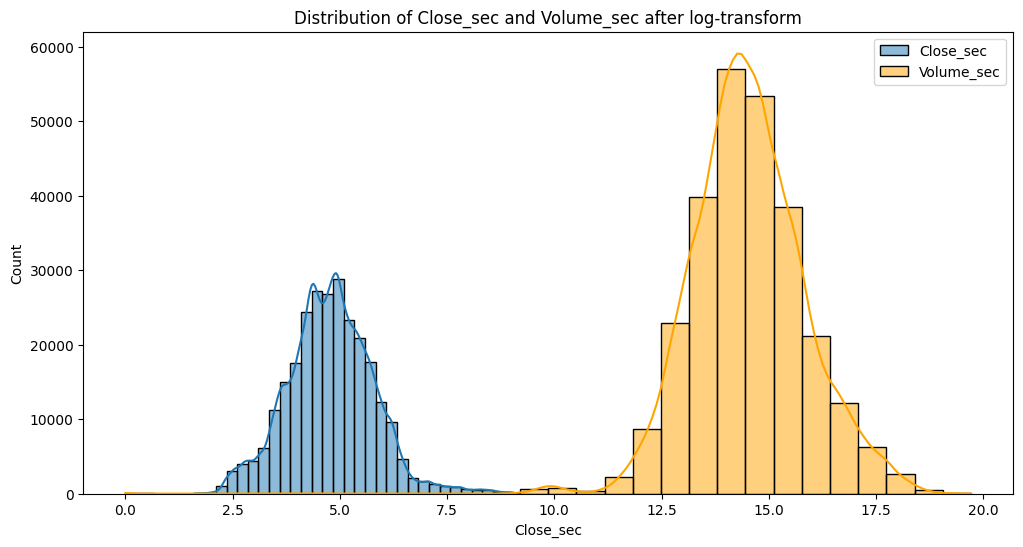

In [12]:

plt.figure(figsize=(12, 6))

# Plotting the distribution of some key columns
sns.histplot(sec_stock_data['Close_sec'], kde=True, bins=30, label='Close_sec')
sns.histplot(sec_stock_data['Volume_sec'], kde=True, bins=30, label='Volume_sec', color='orange')
plt.legend()
plt.title('Distribution of Close_sec and Volume_sec after log-transform')
plt.show()


#### Much better progress, as you can see from this sample plot showing just two of our features of Close and Volume we have really nice normal distribution.  We can feel good moving forward with our data.

# For the last phase of our preprocessing notebook we can now move on to scaling our dataframe.

In [13]:
# We will need to temporarily drop the Ticker column as it is a float value.  We will create a variable for it now, and use it later to bring it back when needed.
tickers = sec_stock_data['ticker'].values
sec_stock_data = sec_stock_data.drop(columns = ['ticker'])

# Initiate the scaler and transform the data.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(sec_stock_data)
sec_stock_scaled = pd.DataFrame(scaled_data, index = sec_stock_data.index, columns = sec_stock_data.columns)

sec_stock_scaled['ticker'] = tickers
print(sec_stock_scaled.head())

            Close_sec  Volume_sec  Open_sec  High_sec   Low_sec   SMA_sec  \
Date                                                                        
2019-03-14  -0.160076   -0.558310 -0.144806 -0.158242 -0.146533 -0.116932   
2019-03-15  -0.166243    0.087049 -0.160989 -0.166353 -0.153977 -0.116932   
2019-03-18  -0.195843   -0.044652 -0.166278 -0.177272 -0.186554 -0.116932   
2019-03-19  -0.190798   -0.464214 -0.193156 -0.201280 -0.185235 -0.116932   
2019-03-20  -0.181681   -0.246529 -0.178433 -0.175411 -0.171332 -0.116932   

             EMA_sec   RSI_sec   BBM_sec   BBU_sec  ...  \
Date                                                ...   
2019-03-14 -0.155008  0.691244 -0.116932 -0.127101  ...   
2019-03-15 -0.155250  0.691244 -0.116932 -0.127101  ...   
2019-03-18 -0.156629  0.691244 -0.116932 -0.127101  ...   
2019-03-19 -0.157763  0.691244 -0.116932 -0.127101  ...   
2019-03-20 -0.158501  0.691244 -0.116932 -0.127101  ...   

            Momentum_7_Lag_Std_1_3_sec  Moment

#### This looks good, let's save it so we can use later on in future notebooks.

In [14]:


sec_stock_scaled.to_csv(os.path.join(project_root, 'data', 'sec_stock_preprocessed.csv'), index = True)


### In summary we have taken our raw secondary stock data that we generated from our generate_secondary_stocks.py script and have preprocessed it for further purposes.  We have created a 3-day lag window and our custom features, addressed any missing values and imputed accordingly, and looked at outliers a bit and making sure that we established normal distribution in at least a few of our features for good measure.  We ended this notebook by scaling our new dataframe using StandardScaler so that it is ready to go upon next use.